# Imports

In [1]:
%load_ext autoreload
%autoreload 2
# from src.vnc import run_vnc_simulation


import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
from pathlib import Path
from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
import jax
# jax.config.update("jax_enable_x64", True)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Use GPU 0
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
import sparse

from src.optimized_vnc import *
from src.plot_utils import *


In [2]:
experiment='Stim_Neurons'
with initialize(version_base=None, config_path="../configs"):
    cfg=compose(config_name='config.yaml', overrides= [f"experiment={experiment}", "paths=glados", "version=debug", f'run_id=Testing'],return_hydra_config=True,)
    HydraConfig.instance().set_config(cfg)

for k in cfg.paths.keys():
    if (k != 'user'):
        cfg.paths[k] = Path(cfg.paths[k])
        cfg.paths[k].mkdir(parents=True, exist_ok=True)




# experiment='default'
# with initialize(version_base=None, config_path="../configs"):
#     cfg_old=compose(config_name='config.yaml', overrides= [f"experiment={experiment}", "paths=glados", "version=debug", f'run_id=Testing'],return_hydra_config=True,)
#     HydraConfig.instance().set_config(cfg_old)

# for k in cfg_old.paths.keys():
#     if (k != 'user'):
#         cfg_old.paths[k] = Path(cfg_old.paths[k])
#         cfg_old.paths[k].mkdir(parents=True, exist_ok=True)


In [ ]:
print("Loading network configuration...")
W_table = load_wTable(cfg.experiment.dfPath)
n_stim_configs = len(cfg.experiment.stimNeurons)
# Prepare parameters
neuron_params = prepare_neuron_params(cfg, W_table)
sim_params = prepare_sim_params(cfg, n_stim_configs, neuron_params.W.shape[0])
simulation_type = "baseline"

results = run_simulation_batched(
    neuron_params, sim_params, simulation_type,
    batch_size=None
)


# Load results

In [ ]:
# results = run_vnc_simulation_optimized(cfg)
# save_path = cfg.paths.ckpt_dir  / "bdn2.npz"

results = sparse.load_npz(cfg.paths.ckpt_dir  / "bdn2.npz").todense().astype(np.float32)

# Testing Shuffle

In [ ]:
params, config = load_vnc_net(cfg)
simulator = OptimizedSimulator(params, config)
# W, W_table = load_connectivity(cfg)

In [ ]:
work_queue = simulator._create_work_queue()

In [ ]:
from src.shuffle_utils import shuffle_W

In [ ]:
newkey, key = jax.random.split(work_queue[0]['seed'])
idxs = params.inh_dn_idxs
W = params.W
W_shuff = shuffle_W(W, key, idxs, independent=True)


# stim neurons for dn screen

In [ ]:
W, W_table = load_connectivity(cfg)
# CHANGE DEFAULTS
allExcDNs = W_table.loc[(W_table["class"] == "descending neuron") & (W_table["predictedNt"] == "acetylcholine")]
stimNeurons = allExcDNs.index.to_list()
stimNeurons = [[neuron] for neuron in stimNeurons]
nSims = len(stimNeurons)

# Check param dists

In [ ]:
from src.Archive.vnc_old import load_vnc_net as load_vnc_net_old
params, config = load_vnc_net(cfg)
params_old, config_old = load_vnc_net_old(cfg_old)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()
for n, (orig,new) in enumerate(zip([params_old.tau,params_old.threshold,params_old.a,params_old.fr_cap], [params.tau, params.threshold, params.a, params.fr_cap])):
    axs[n].hist(orig.flatten(), bins=50, alpha=0.5, label='Sampled', density=True)
    axs[n].hist(new.flatten(), bins=50, alpha=0.5, label='Original', density=True)
    axs[n].set_title(f"Histogram of {n}")
    axs[n].set_xlabel(n)
    axs[n].set_ylabel("Frequency")

# Testing batchsizes

In [ ]:
params, config = load_vnc_net(cfg)

In [ ]:
batch_size = 200#2**6# cfg.experiment.batch_size
# batch_idx = 0  # Example batch index
work_queue = []
ntotal = 0
n_stim_configs = len(params.input_currents_list)
n_param_sets = n_replicates = 12345 # len(params.tau)
for stim_idx in range(n_stim_configs):
    for param_idx in range(n_param_sets):
        work_queue.append({"stim_idx":stim_idx, "param_idx":param_idx, "total_count": ntotal})
        ntotal +=1
all_results = []
all_metadata = []
n_batches = (len(work_queue) + batch_size - 1) // batch_size
for batch_idx in range(n_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, len(work_queue))
    actual_batch_size = end_idx - start_idx
    batch_work = work_queue[start_idx:end_idx]

    batch_params = {
        'tau_batch': jnp.array([item['total_count'] for item in batch_work]),
        'stim_batch': jnp.array([item['stim_idx'] for item in batch_work]),
        'param_batch': jnp.array([item['param_idx'] for item in batch_work])
    }

    batch_metadata = [
        {'param_idx': item['param_idx'], 'stim_idx': item['stim_idx'], 'total_count': item['total_count']} 
        for item in batch_work
    ]
    
    batch_size = len(batch_params['tau_batch'])
    n_devices = jax.device_count()
    # Pad to make divisible by n_devices
    pad_size = n_devices - (batch_size % n_devices) if batch_size % n_devices != 0 else 0
    print(pad_size, batch_size, n_devices)
    device_data = {}
    for key, data in batch_params.items():
    #     if pad_size > 0:
    #         # Pad with the last element
    #         if data.ndim == 1:
    #             padding = jnp.repeat(data[-1:], pad_size, axis=0)
    #         else:
    #             padding = jnp.repeat(data[-1:], pad_size, axis=0)
    #         data_padded = jnp.concatenate([data, padding])
    #     else:
    #         data_padded = data
        
        # Reshape for devices
        device_data[key] = data.reshape(n_devices, -1, *data.shape[1:])
    print(f"device_data: {device_data['tau_batch'].shape}, {device_data['stim_batch'].shape}, {device_data['param_batch'].shape}")


    batch_results = device_data['tau_batch'][:,:,None,None]
    batch_results_flat = batch_results.reshape(-1, *batch_results.shape[2:])
    batch_results_trimmed = batch_results_flat[:actual_batch_size]
    batch_results_trimmed = jax.device_put(batch_results_trimmed, jax.devices('cpu')[0])
    batch_results_trimmed = jnp.where(
            jnp.isinf(batch_results_trimmed) | jnp.isnan(batch_results_trimmed), 
            0, batch_results_trimmed
        )
    all_results.extend(batch_results_trimmed)
    all_metadata.extend(batch_metadata)
    print(f'batch:{batch_idx}, {batch_results_trimmed.squeeze()}')


In [ ]:
batch_size % n_devices, batch_size, n_devices
# batch_params['tau_batch'], len(work_queue)

In [ ]:

results_by_stim = {}
results_by_stim_total_ind = {}
# Initialize batch_results_trimmed containers
for stim_idx in range(n_stim_configs):
    results_by_stim[stim_idx] = [None] * n_param_sets
    results_by_stim_total_ind[stim_idx] = [None] * n_param_sets

# Place results in correct positions using metadata
for batch_results_trimmed, metadata in zip(all_results, all_metadata):
    param_idx = metadata['param_idx']
    stim_idx = metadata['stim_idx']
    
    # Validate indices
    if param_idx >= n_param_sets or stim_idx >= n_stim_configs:
        print(f"Warning: Invalid indices param_idx={param_idx}, stim_idx={stim_idx}")
        continue
    results_by_stim_total_ind[stim_idx][param_idx] = metadata['total_count']
    results_by_stim[stim_idx][param_idx] = batch_results_trimmed

# Convert to arrays and validate completeness
for stim_idx in results_by_stim:
    results_list = results_by_stim[stim_idx]
    result_inds = results_by_stim_total_ind[stim_idx]
    if (jnp.diff(jnp.array(results_by_stim_total_ind[stim_idx])) > 1).any():
        print(f"Warning: Inconsistent results for stimulus {stim_idx}, indices: {result_inds}")
    # Check for missing results
    missing_indices = [i for i, batch_results_trimmed in enumerate(results_list) if batch_results_trimmed is None]
    if missing_indices:
        print(f"Warning: Missing results for stimulus {stim_idx} at parameter indices: {missing_indices}")
        # Fill missing with zeros (same shape as other results)
        ref_shape = next(r.shape for r in results_list if r is not None)
        for idx in missing_indices:
            results_list[idx] = jnp.zeros(ref_shape)
    
    results_by_stim[stim_idx] = jnp.array(results_list)
results2 = jnp.stack([results_by_stim[n] for n in results_by_stim.keys()])


In [ ]:
results.shape

# Plot Results

In [ ]:
np.where(np.all(np.sum(results,axis=-1)==0,axis=-1))

In [ ]:
R = results[0][21]


wTable = pd.read_csv("../data/manc t1 connectome data/wTable_20231020_DNtoMN_unsorted_withModules.csv",index_col=0)
nonMns = wTable.loc[(wTable["bodyId"]==10093) | (wTable["bodyId"]==10707) | (wTable["bodyId"]==13905) | (wTable["bodyId"]==11751)]
mnIdxs = wTable.loc[wTable["class"]=="motor neuron"].index


for i in nonMns.index:
# for i in mnIdxs:
    plt.plot(R[i])
    #plt.plot(Rtsp[i])

print(np.mean(R))


## Testing osc score

In [ ]:
results = sparse.load_npz(cfg.paths.ckpt_dir  / "bdn2.npz").todense().astype(np.float32)

wTable = pd.read_csv("../data/manc t1 connectome data/wTable_20231020_DNtoMN_unsorted_withModules.csv",index_col=0)
nonMns = (wTable.loc[(wTable["bodyId"]==10093) | (wTable["bodyId"]==10707) | (wTable["bodyId"]==13905) | (wTable["bodyId"]==11751)]).values
mn_idxs = wTable.loc[wTable["class"]=="motor neuron"].index.values


In [ ]:
from scipy import signal
import numpy as np
def neuron_oscillation_score_helper_old(activity,prominence):
    activity = activity-np.min(activity)
    activity = 2 * activity/np.max(activity) - 1

    autocorr = np.correlate(activity,activity,mode="full") / np.inner(activity,activity)
    lags = signal.correlation_lags(len(activity),len(activity))
    autocorr = autocorr[lags>0]
    lags = lags[lags>0]

    peaks, peakProperties = signal.find_peaks(autocorr,height=(None,None),prominence=prominence)
    if len(peaks) > 0:
        score = np.min([np.max(peakProperties["peak_heights"]),np.max(peakProperties["prominences"])])
        frequency = 1 / peaks[np.argmax(peakProperties["prominences"])]
    else:
        score = 0
        frequency = 0

    return score, frequency

def neuron_oscillation_score_old(activity, returnFrequency=False,prominence=0.05):
    rawScore, frequency = neuron_oscillation_score_helper_old(activity,prominence)
    # normalize to sine wave of the same frequency and duration
    if rawScore == 0:
        score = 0
    else:
        refSinScore, _ = neuron_oscillation_score_helper_old(np.sin(2*np.pi*frequency*np.arange(len(activity))),prominence)
        refCosScore, _ = neuron_oscillation_score_helper_old(np.cos(2*np.pi*frequency*np.arange(len(activity))),prominence)
        refScore = np.max((refSinScore,refCosScore))
        score = rawScore / refScore

    if returnFrequency:
        return score, frequency
    else:
        return score

def sim_oscillation_score_old(R,activeMnIdxs,start=None,end=None,returnFrequency=False):
    """calculate oscillation score for a simulation"""
    if start is None:
        start = 0
    if end is None:
        end = -1

    if returnFrequency:
        neuronOscillationScores = []
        frequencies = []

        for j in activeMnIdxs:
            score, freq = neuron_oscillation_score_old(R[j][start:end],returnFrequency=True)
            neuronOscillationScores.append(score)
            frequencies.append(freq)
        return np.mean(neuronOscillationScores), np.nanmean(frequencies)
        
    else:
        neuronOscillationScores = [neuron_oscillation_score_old(R[j][start:end]) for j in activeMnIdxs] # scores for each neuron
        return np.mean(neuronOscillationScores) # average for the simulation
    
    

In [ ]:
R = results[0][19]
np_R = np.asarray(R)
maxFrs = np.max(np_R,axis=-1)
activeMnIdxs = mnIdxs[maxFrs[mnIdxs]>0]
plt.plot(np_R[activeMnIdxs].T)
plt.show()

In [ ]:
R = results[1][1]

score, freq = sim_oscillation_score_old(R,activeMnIdxs,start=250,end=None,returnFrequency=True)
print(f"Score: {score}, Frequency: {freq}")

In [ ]:
from src.sim_utils import neuron_oscillation_score


In [ ]:
start = int(cfg.sim.pulseStart/cfg.sim.dt) + 100
R = results[0][0]

max_frs = jnp.max(R, axis=-1)
active_mn_idxs = mn_idxs[max_frs[...,mn_idxs] > 0]
activity = R[active_mn_idxs][..., start:]  # Adjusted to match the original code's start index

score, frequency = jax.vmap(neuron_oscillation_score, in_axes=(0, None))(activity, 0.05)
print(f"Score: {jnp.nanmean(score)}, Frequency: {jnp.nanmean(frequency)}")

# Testing Pruning

In [5]:
from src.sim_utils import neuron_oscillation_score

experiment='prune_test'
with initialize(version_base=None, config_path="../configs"):
    cfg=compose(config_name='config.yaml', overrides= [f"experiment={experiment}", "paths=glados", "version=debug", f'run_id=Testing'],return_hydra_config=True,)
    HydraConfig.instance().set_config(cfg)

for k in cfg.paths.keys():
    if (k != 'user'):
        cfg.paths[k] = Path(cfg.paths[k])
        cfg.paths[k].mkdir(parents=True, exist_ok=True)



##### Temp parames testing

In [ ]:
results = run_vnc_simulation_optimized(cfg)

In [ ]:
def extract_nth_filtered_pytree(pytree, n, path_filter, key_list=['tau', 'threshold', 'a', 'fr_cap', 'W_mask']):
    """
    path_filter: function that takes key_path tuple and returns True/False
    """
    def process_leaf(key_path, leaf):
        if path_filter(key_path, key_list):
            return leaf[n:n+1]
        return leaf

    return jax.tree.map_with_path(process_leaf, pytree)

def path_filter(key_path, key_list):
    """
    Filter function that checks if the key_path contains specific keys.
    """
    return key_path[0].name in key_list and key_path != []

In [ ]:
temp_params = extract_nth_filtered_pytree(neuron_params, 0, path_filter)
for att in temp_params:
    if jnp.ndim(att) > 0:
        print(att.shape)

In [340]:
total_sims = 1
batch_size = calculate_optimal_batch_size(sim_params.n_neurons, len(sim_params.t_axis))
start_idx = i * batch_size
end_idx = min((i + 1) * batch_size, total_sims)

batch_indices = jnp.arange(start_idx, end_idx)

temp_params = extract_nth_filtered_pytree(neuron_params, 0, path_filter)

batch_results = process_batch_baseline(temp_params, sim_params, jnp.zeros(1,dtype=jnp.int32)).squeeze() # Single simulation result

In [7]:
W_table = load_wTable(cfg.experiment.dfPath)
n_stim_configs = len(cfg.experiment.stimNeurons)

# Prepare parameters
neuron_params = prepare_neuron_params(cfg, W_table)
sim_params = prepare_sim_params(cfg, n_stim_configs, neuron_params.W.shape[0])

# results = sparse.load_npz(cfg.paths.ckpt_dir  / "bdn2.npz").todense().astype(np.float32)

W_table = pd.read_csv("../data/manc t1 connectome data/wTable_20231020_DNtoMN_unsorted_withModules.csv",index_col=0)
nonMns = (W_table.loc[(W_table["bodyId"]==10093) | (W_table["bodyId"]==10707) | (W_table["bodyId"]==13905) | (W_table["bodyId"]==11751)]).values
mnIdxs = W_table.loc[W_table["class"]=="motor neuron"].index.values

# n_sims = results.shape[0]

In [248]:
all_neurons = np.arange(sim_params.n_neurons)
mn_idxs = jnp.asarray(W_table.loc[W_table["class"]=="motor neuron"].index.values)
in_idxs = jnp.setdiff1d(all_neurons, mn_idxs)
removed_stim_neurons = jnp.full([n_sims, neuron_params.removed_neurons.shape[-1]], -1, dtype=jnp.int32)
prev_neurons_put_back = jnp.full([n_sims, neuron_params.removed_neurons.shape[-1]], -1, dtype=jnp.int32)


######

"""JAX-compatible version of run_pruning_from_params"""
max_neurons = 4561  # Maximum neurons to put back in a single iteration
n_sims = sim_params.n_param_sets * sim_params.n_stim_configs

# Initialize state arrays
level = jnp.zeros(n_sims, dtype=jnp.int32)
last_removed = jnp.full([n_sims, neuron_params.removed_neurons.shape[-1]], -1, dtype=jnp.int32)  # Use -1 for None
neurons_put_back = jnp.full([n_sims, neuron_params.removed_neurons.shape[-1]], -1, dtype=jnp.int32)
min_circuit = jnp.full(n_sims, False)

# Initialize probabilities
p_arrays = []
for i in range(n_sims):
    exclude_mask = jnp.isin(in_idxs, jnp.concatenate([removed_stim_neurons[i]]))
    p_i = removal_probability(jnp.ones_like(in_idxs), exclude_mask)
    p_arrays.append(p_i)

p_arrays[0]

Array([0.00022512, 0.00022512, 0.00022512, ..., 0.00022512, 0.00022512,
       0.00022512], dtype=float32)

In [249]:
oscillation_threshold=0.1
iter_start = 0  # Starting iteration
# Create master random key
# master_key = random.PRNGKey(neuron_params.seeds, 42)

# Main pruning loop
iteration = iter_start
max_iterations = 1000  # Safety limit

# while not jnp.all(min_circuit) and iteration < max_iterations:
print(f"Iteration {iteration}")

# Resample seeds for non-converged simulations
resample_idxs = jnp.where(~min_circuit)[0]

# Run simulation (this would call your simulation function)
# For now, creating dummy data - replace with actual simulation results
Rs = [jnp.ones((len(in_idxs) + len(mn_idxs), 1000)) for _ in range(n_sims)]
# Update each simulation state
# for i in range(n_sims):
i = 0  # Example index, replace with actual loop
# if min_circuit[i]:
#     continue
    
state = (
    neuron_params.removed_neurons,  # array for removed neurons
    neurons_put_back[i],
    last_removed[i],
    p_arrays[i],
    level[i],
    removed_stim_neurons[i],
    neuron_params.seeds[i],
)
state
# new_state = update_single_sim_state(
#     state, Rs[i], mn_idxs, in_idxs, oscillation_threshold
# )

Iteration 0


(Array([-1, -1, -1, ..., -1, -1, -1], dtype=int32),
 Array([-1, -1, -1, ..., -1, -1, -1], dtype=int32),
 Array([-1, -1, -1, ..., -1, -1, -1], dtype=int32),
 Array([0.00022512, 0.00022512, 0.00022512, ..., 0.00022512, 0.00022512,
        0.00022512], dtype=float32),
 Array(0, dtype=int32),
 Array([-1, -1, -1, ..., -1, -1, -1], dtype=int32),
 Array([ 726863002, 2265770120], dtype=uint32))

In [250]:

@jax.jit
def compute_oscillation_score(activity, active_mask, prominence=0.05):
    # Compute scores for all neurons (will be NaN for inactive ones)
    scores = jax.vmap(
        lambda activity_row, mask: jax.lax.cond(
            mask,
            lambda x: neuron_oscillation_score(x, prominence=prominence),
            lambda x: (jnp.nan, jnp.nan),
            activity_row
        ),
        in_axes=(0, 0)
    )(activity, active_mask)
    score_values, frequencies = scores
    # Compute mean of valid scores
    oscillation_score = jnp.nanmean(score_values)
    frequencies = jnp.nanmean(frequencies)
    return oscillation_score, frequencies

In [ ]:
max_frs = jnp.max(R, axis=-1)
mn_mask = jnp.isin(jnp.arange(R.shape[0]), mn_idxs)
active_mask = ((max_frs>0) & mn_mask)  # Combine max_frs with mn_mask to get active neurons

oscillation_score, frequencies = compute_oscillation_score(R, active_mask, prominence=0.05)


In [ ]:
start = int(cfg.sim.pulseStart/cfg.sim.dt) + 100

max_frs = jnp.max(R, axis=-1)
active_mn_idxs = mn_idxs[max_frs[...,mn_idxs] > 0]
activity = R[active_mn_idxs][..., start:]  # Adjusted to match the original code's start index

score, frequency = jax.vmap(neuron_oscillation_score, in_axes=(0, None))(activity, 0.05)
print(f"Score: {jnp.nanmean(score)}, Frequency: {jnp.nanmean(frequency)}")

In [112]:
new_p = removal_probability(max_frs[in_idxs], exclude_mask)

In [256]:
new_remove_neurons = jnp.setdiff1d(remove_neurons, jnp.array([last_removed]), size=len(remove_neurons), fill_value=-1)

In [270]:
(remove_neurons, neurons_put_back, last_removed, p, level, removed_stim_neurons, key) = state

@jax.jit
def get_pos_val_indices(arr, max_indices=None):
    if max_indices is None:
        max_indices = arr.shape[0]  # Use full array size as max
    
    indices = jnp.where(arr >= 0, size=max_indices, fill_value=-1)[0]
    return indices

@jax.jit
def continue_branch(key):
    # Get max firing rates for all neurons
    max_frs = jnp.max(R, axis=1)
    
    # Remove silent interneurons
    silent_mask = (max_frs == 0)
    silent_in_mask = silent_mask[in_idxs]
    silent_ins = jnp.where(silent_in_mask, in_idxs, -1)
    # silent_ins = silent_ins[silent_ins >= 0]  # Filter out -1 values

    new_remove_neurons = get_pos_val_indices(silent_ins)

    # Update probabilities based on firing rates
    exclude_mask = jnp.isin(in_idxs, neurons_put_back) | jnp.isin(in_idxs, removed_stim_neurons)
    new_p = removal_probability(max_frs[in_idxs], exclude_mask)
    
    # Check if we can continue
    p_sum = jnp.sum(new_p)
    converged = p_sum <= 1e-10
    
    key, subkey = random.split(key)
    neuron_idx = jax_choice(subkey, jnp.arange(len(in_idxs)), new_p)
    new_neuron_to_remove = neurons_put_back.at[in_idxs[neuron_idx]].set(1)

    new_remove_neurons = jnp.where((new_remove_neurons>0 )| (new_neuron_to_remove>0), 1, -1)

    return (new_remove_neurons, neurons_put_back, new_neuron_to_remove,
            new_p, level, removed_stim_neurons, key, converged)
    
@jax.jit
def reset_branch(key):
    # Put back the last removed neuron
    new_remove_neurons = jnp.setdiff1d(remove_neurons, jnp.array([last_removed]), size=len(remove_neurons), fill_value=-1)
    # Combine neurons_put_back and last_removed into a single mask
    new_neurons_put_back = jnp.where((neurons_put_back >= 0) & (last_removed >= 0), 1, -1)


    # Update probabilities to exclude put-back neurons
    exclude_mask = jnp.isin(in_idxs, new_neurons_put_back) | jnp.isin(in_idxs, removed_stim_neurons)
    new_p = removal_probability(jnp.ones(len(in_idxs)), exclude_mask)
    
    # Check if we can continue
    p_sum = jnp.sum(new_p)
    converged = p_sum <= 1e-10
    
    key, subkey = random.split(key)
    neuron_idx = jax_choice(subkey, jnp.arange(len(in_idxs)), new_p)
    new_neuron_to_remove = neurons_put_back.at[in_idxs[neuron_idx]].set(1)
    
    new_remove_neurons = jnp.where((new_remove_neurons>0 )| (new_neuron_to_remove>0), 1, -1)
    
    return (new_remove_neurons, new_neurons_put_back, new_neuron_to_remove, 
            new_p, level, removed_stim_neurons, key, converged)

In [51]:
def print_pytree(pytree):
    """
    path_filter: function that takes key_path tuple and returns True/False
    """
    def process_leaf(key_path, leaf):
       print(f"Key Path: {key_path[0]}, Leaf: {leaf.shape}")

    return jax.tree.map_with_path(process_leaf, pytree)
print_pytree(state)

Key Path: .W_mask, Leaf: (1, 4561, 4561)
Key Path: .in_idxs, Leaf: (4442,)
Key Path: .level, Leaf: (1,)
Key Path: .removed_neurons, Leaf: (1, 4442)
Key Path: .removed_stim_neurons, Leaf: (1, 4442)
Key Path: .neurons_put_back, Leaf: (1, 4442)
Key Path: .last_removed, Leaf: (1, 4442)
Key Path: .remove_p, Leaf: (1, 4442)
Key Path: .min_circuit, Leaf: (1,)
Key Path: .keys, Leaf: (1, 2)


Pruning_state(W_mask=None, in_idxs=None, level=None, removed_neurons=None, removed_stim_neurons=None, neurons_put_back=None, last_removed=None, remove_p=None, min_circuit=None, keys=None)

In [286]:
new_state = update_single_sim_state(state, R, mn_idxs, in_idxs, oscillation_threshold)
print('Next state:')
for att in new_state:
    if jnp.ndim(att) > 0:
        print(jnp.where(att>0))

Next state:
(Array([   1,    2,    3, ..., 4241, 4242, 4243], dtype=int32),)
(Array([], shape=(0,), dtype=int32),)
(Array([2324], dtype=int32),)
(Array([   0,    1,    2, ..., 4439, 4440, 4441], dtype=int32),)
(Array([], shape=(0,), dtype=int32),)
(Array([0, 1], dtype=int32),)


In [271]:
# (remove_neurons, neurons_put_back, last_removed, p, level, removed_stim_neurons, key)
next_state = continue_branch(key)
reset_state = reset_branch(key)
next_state, reset_state

((Array([-1,  1,  1, ..., -1, -1, -1], dtype=int32, weak_type=True),
  Array([-1, -1, -1, ..., -1, -1, -1], dtype=int32),
  Array([-1, -1, -1, ..., -1, -1, -1], dtype=int32),
  Array([0.00018046, 0.00018046, 0.00018046, ..., 0.00018046, 0.00018046,
         0.00018046], dtype=float32),
  Array(0, dtype=int32),
  Array([-1, -1, -1, ..., -1, -1, -1], dtype=int32),
  Array([ 906402197, 4248685058], dtype=uint32),
  Array(False, dtype=bool)),
 (Array([-1, -1, -1, ..., -1, -1, -1], dtype=int32, weak_type=True),
  Array([-1, -1, -1, ..., -1, -1, -1], dtype=int32, weak_type=True),
  Array([-1, -1, -1, ..., -1, -1, -1], dtype=int32),
  Array([0.00022512, 0.00022512, 0.00022512, ..., 0.00022512, 0.00022512,
         0.00022512], dtype=float32),
  Array(0, dtype=int32),
  Array([-1, -1, -1, ..., -1, -1, -1], dtype=int32),
  Array([ 906402197, 4248685058], dtype=uint32),
  Array(False, dtype=bool)))

In [272]:
(new_remove_neurons, new_neurons_put_back, new_neuron_to_remove,new_p, new_level, new_removed_stim_neurons, new_key, cnew_onverged) = next_state


In [ ]:
(reset_remove_neurons, reset_neurons_put_back, reset_neuron_to_remove, reset_p, reset_level, reset_removed_stim_neurons, reset_key, reset_converged) = reset_state

In [280]:
print('Next state:')
for att in next_state:
    if jnp.ndim(att) > 0:
        print(jnp.where(att>0))
print('Reset state:')
for att in reset_state:
    if jnp.ndim(att) > 0:
        print(jnp.where(att>0))

Next state:
(Array([   1,    2,    3, ..., 4241, 4242, 4243], dtype=int32),)
(Array([], shape=(0,), dtype=int32),)
(Array([2324], dtype=int32),)
(Array([   0,    1,    2, ..., 4439, 4440, 4441], dtype=int32),)
(Array([], shape=(0,), dtype=int32),)
(Array([0, 1], dtype=int32),)
Reset state:
(Array([2324], dtype=int32),)
(Array([], shape=(0,), dtype=int32),)
(Array([2324], dtype=int32),)
(Array([   0,    1,    2, ..., 4439, 4440, 4441], dtype=int32),)
(Array([], shape=(0,), dtype=int32),)
(Array([0, 1], dtype=int32),)


In [22]:
simulation_type = "baseline"
Rs = run_simulation_batched(
    neuron_params, sim_params, simulation_type,
    batch_size=getattr(cfg.experiment, "batch_size", None)
)

Running 1 simulations with batch size 10
Batch 1/1 completed


In [ ]:
# Get active MN activity using JAX-compatible approach
max_frs = jnp.max(R, axis=-1)
mn_mask = jnp.isin(jnp.arange(R.shape[0]), mn_idxs)
active_mask = ((max_frs>0) & mn_mask)  # Combine max_frs with mn_mask to get active neurons

oscillation_score, _ = compute_oscillation_score(R[..., start:], active_mask, prominence=0.05)

(1, 1, 4561, 2000)

In [276]:
oscillation_threshold = 0.1
# Load data (this part stays on CPU)
w_table = load_wTable(cfg.experiment.dfPath)
n_stim_configs = len(cfg.experiment.stimNeurons)

## Initialize parameters
neuron_params = prepare_neuron_params(cfg, w_table)
sim_params = prepare_sim_params(cfg, n_stim_configs, neuron_params.W.shape[0])
all_neurons = w_table.index.to_numpy()


# Initialize state
n_sims = sim_params.n_param_sets * sim_params.n_stim_configs
mn_idxs = jnp.asarray(w_table.loc[w_table["class"]=="motor neuron"].index.values)
in_idxs = jnp.setdiff1d(all_neurons, mn_idxs)
removed_stim_neurons = jnp.full([n_sims, neuron_params.removed_neurons.shape[-1]], -1, dtype=jnp.int32)
prev_neurons_put_back = jnp.full([n_sims, neuron_params.removed_neurons.shape[-1]], -1, dtype=jnp.int32)


((Array([   1,    2,    3, ..., 4241, 4242, 4243], dtype=int32),),
 (Array([], shape=(0,), dtype=int32),),
 (Array([2324], dtype=int32),),
 (Array([], shape=(0,), dtype=int32),))

## full pipeline testing

In [3]:
from src.prune_net import *

In [6]:
oscillation_threshold = 0.2
# Load data (this part stays on CPU)
w_table = load_wTable(cfg.experiment.dfPath)
n_stim_configs = len(cfg.experiment.stimNeurons)
## Initialize parameters
neuron_params = prepare_neuron_params(cfg, w_table)
sim_params = prepare_sim_params(cfg, n_stim_configs, neuron_params.W.shape[0])
all_neurons = w_table.index.to_numpy()
n_sims = sim_params.n_param_sets * sim_params.n_stim_configs
mn_idxs = jnp.asarray(w_table.loc[w_table["class"]=="motor neuron"].index.values)
in_idxs = jnp.setdiff1d(all_neurons, mn_idxs)
clip_start = int(cfg.sim.pulseStart / cfg.sim.dt) + 100

total_sims = sim_params.n_stim_configs * sim_params.n_param_sets
batch_size = getattr(cfg.experiment, "batch_size", None)
if batch_size is None:
    batch_size = calculate_optimal_batch_size(
        sim_params.n_neurons, len(sim_params.t_axis)
    )
    
batch_func = process_batch_prune
# Create parallel version for multiple devices
if jax.device_count() > 1:
    batch_func = pmap(batch_func, axis_name="device", in_axes=(None, None, 0))
    batch_size = (batch_size // jax.device_count()) * jax.device_count()

print(f"Running {total_sims} simulations with batch size {batch_size}")

# Process in batches
all_results = []
n_batches = (total_sims + batch_size - 1) // batch_size

# for i in range(n_batches):
i = 0 
start_idx = i * batch_size
end_idx = min((i + 1) * batch_size, total_sims)

batch_indices = jnp.arange(start_idx, end_idx)

# Pad if necessary for pmap
if jax.device_count() > 1 and len(batch_indices) < batch_size:
    pad_size = batch_size - len(batch_indices)
    batch_indices = jnp.concatenate([
        batch_indices, 
        jnp.repeat(batch_indices[-1], pad_size)
    ])


Running 2 simulations with batch size 10


In [7]:

mn_idxs = neuron_params.mn_idxs
all_neurons = jnp.arange(neuron_params.W.shape[-1])
in_idxs = jnp.setdiff1d(all_neurons, mn_idxs)

clip_start = int(sim_params.pulse_start / sim_params.dt) + 100
# Initialize state
n_sims = sim_params.n_param_sets * sim_params.n_stim_configs
W_mask = jnp.full((n_sims, neuron_params.W.shape[0], neuron_params.W.shape[1]), 1, dtype=jnp.float32)
interneuron_mask = jnp.full((n_sims, W_mask.shape[-1]),fill_value=False, dtype=jnp.bool_)
interneuron_mask = interneuron_mask.at[:,in_idxs].set(True)
level = jnp.zeros((n_sims,1), dtype=jnp.int32)
total_removed_neurons = jnp.full((n_sims, W_mask.shape[-1]), False, dtype=jnp.bool)
removed_stim_neurons = jnp.full([n_sims, total_removed_neurons.shape[-1]], False, dtype=jnp.bool)
neurons_put_back =  jnp.full([n_sims, total_removed_neurons.shape[-1]], False, dtype=jnp.bool)
last_removed =  jnp.full([n_sims, total_removed_neurons.shape[-1]], False, dtype=jnp.bool) # Use False for None
min_circuit = jnp.full((n_sims,1), False)

# Initialize probabilities
exclude_mask = (~interneuron_mask)
p_arrays = jax.vmap(removal_probability)(jnp.ones(len(interneuron_mask)), exclude_mask)

# initialize pruning state
state = Pruning_state(
    W_mask=W_mask,
    interneuron_mask=interneuron_mask,
    level=level,
    total_removed_neurons=total_removed_neurons,
    removed_stim_neurons=removed_stim_neurons,
    neurons_put_back=neurons_put_back,
    last_removed=last_removed,
    remove_p=p_arrays,
    min_circuit=min_circuit,
    keys=neuron_params.seeds
)

iter_start = 0  # Starting iteration
# Main pruning loop
iteration = iter_start
max_iterations = 3  # Safety limit
while not jnp.all(min_circuit) and (iteration < max_iterations):
    start_time = time.time()
    print(f"Iteration {iteration}")
    # Update neuron parameters W_mask based on the current state
    neuron_params = update_neuron_params(neuron_params, W_mask=state.W_mask)
    # Run simulation (this would call your simulation function)
    # Reshape for devices if using pmap
    if jax.device_count() > 1:
        batch_indices = batch_indices.reshape(jax.device_count(), -1)
        batch_results = batch_func(neuron_params, sim_params, batch_indices)
        batch_results = batch_results.reshape(-1, *batch_results.shape[2:])
        batch_results = batch_results[:end_idx - start_idx]  # Remove padding
    else:
        batch_results = batch_func(neuron_params, sim_params, batch_indices)
    
    n = 0 
    state = jax.vmap(update_single_sim_state, in_axes=(0, 0, None, None, None))(state, batch_results, mn_idxs, oscillation_threshold, clip_start)
    iteration += 1
    
    elapsed = time.time() - start_time
    print(f"  Total time: {elapsed:.2f} seconds")

# batch_results = jax.device_put(batch_results, jax.devices("cpu")[0])
# all_results.append(batch_results)
# print(f"Batch {i + 1}/{n_batches} completed")

# del batch_results  # Free memory
# gc.collect()  # Force garbage collection

# Combine results
# results = jnp.concatenate(all_results, axis=0)

Iteration 0
W_mask True


2025-07-21 09:49:02.545831: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-21 09:49:03.018330: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-21 09:49:03.038768: E external/xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng28{k2=4,k3=0} for conv %cudnn-conv = (f32[1,9122,3759]{2,1,0}, u8[0]{0}) custom-call(%bitcast.20, %bitcast.21), window={size=1880 pad=1879_1879}, dim_labels=bf0_oi0->bf0, feature_group_count=9122, custom_call_target="__cudnn$convForward", metadata={op_name="jit(update_single_sim_state)/jit(main)/jit(compute_oscillation_score)/vmap(jit(neuron_oscillation_score))/jit(neuron_oscillation_score_helper_jax)/jit(correlate)/jit(_conv)/conv_gen

Silent interneurons found: 4244
Silent interneurons found: 4269
Total permanently removed: 4245
Total permanently removed: 4270
Available for testing: 197
Available for testing: 172
Oscillation score: 0.7551005482673645
Oscillation score: 0.887699544429779
Reset condition: False
Reset condition: False
Converged mini_circuit: False
Converged mini_circuit: False
Neurons put back: 0
Neurons put back: 0
  Total time: 24.27 seconds
Iteration 1
W_mask False
Silent interneurons found: 4245
Silent interneurons found: 4270
Total permanently removed: 4246
Total permanently removed: 4271
Available for testing: 196
Available for testing: 171
Oscillation score: 0.7551648020744324
Oscillation score: 0.8877397775650024
Reset condition: False
Reset condition: False
Converged mini_circuit: False
Converged mini_circuit: False
Neurons put back: 0
Neurons put back: 0
  Total time: 18.74 seconds
Iteration 2
W_mask False
Silent interneurons found: 4246
Silent interneurons found: 4271
Total permanently remov

In [8]:
jnp.where(state.neurons_put_back[0])

(Array([], shape=(0,), dtype=int32),)

In [10]:
# initialize pruning state
state = Pruning_state(
    W_mask=W_mask[0],
    interneuron_mask=interneuron_mask[0],
    level=level[0],
    total_removed_neurons=total_removed_neurons[0],
    removed_stim_neurons=removed_stim_neurons[0],
    neurons_put_back=neurons_put_back[0],
    last_removed=last_removed[0],
    remove_p=p_arrays[0],
    min_circuit=min_circuit[0],
    keys=neuron_params.seeds[0],
)
R = batch_results[0]

In [11]:

# Unpack state first to check min_circuit condition
(W_mask, interneuron_mask, level, total_removed_neurons, removed_stim_neurons,
    neurons_put_back, last_removed, remove_p, min_circuit, key) = state

# Get active MN activity using JAX-compatible approach
max_frs = jnp.max(R, axis=-1)
mn_mask = jnp.isin(jnp.arange(R.shape[0]), mn_idxs)
active_mask = ((max_frs>0) & mn_mask)

# Compute oscillation score
oscillation_score, _ = compute_oscillation_score(R[..., clip_start:], active_mask, prominence=0.05)

# Check if oscillation is below threshold
reset_condition = (oscillation_score < oscillation_threshold) | jnp.isnan(oscillation_score)

# === PERMANENTLY REMOVE SILENT INTERNEURONS ===
# Identify currently silent interneurons - these get permanently added to total_removed_neurons
current_silent_interneurons = interneuron_mask & (max_frs <= 0)
# Add silent interneurons to the permanent removal list
permanently_removed_base = total_removed_neurons | current_silent_interneurons

# === CONTINUE BRANCH LOGIC ===
# Update probabilities based on firing rates - exclude non-interneurons and permanently removed
exclude_mask_continue = (~interneuron_mask) | permanently_removed_base
p_continue = removal_probability(max_frs, exclude_mask_continue)

# Sample new neuron to remove (only from available interneurons)
key_continue, subkey_continue = random.split(key)
neuron_idx_continue = jax_choice(subkey_continue, jnp.arange(len(max_frs)), p_continue)

# Update removed_stim_neurons to include the newly selected neuron
removed_stim_continue = removed_stim_neurons.at[neuron_idx_continue].set(True)

# Update total removed neurons: permanently removed + new stimulated neuron
total_removed_continue = permanently_removed_base | removed_stim_continue

# neurons_put_back remains unchanged in continue branch
neurons_put_back_continue = neurons_put_back

# Check convergence for continue branch - no new neurons put back
converged_continue = False

# === RESET BRANCH LOGIC ===
# In reset: keep permanently removed neurons, but allow re-selection of stimulated neurons
# Only restore the last stimulated neuron, keep all silent neurons permanently removed
restored_total_removed = permanently_removed_base  # Keep all silent neurons removed

# Track which stimulated neurons are being put back (restored)
# Neurons that were in removed_stim_neurons but are NOT in permanently_removed_base are being restored
previously_stimulated_neurons = removed_stim_neurons & (~permanently_removed_base)
neurons_put_back_reset = neurons_put_back | previously_stimulated_neurons

# Clear stimulated neuron selections and pick a new one
reset_removed_stim_neurons = jnp.full_like(removed_stim_neurons, False, dtype=jnp.bool_)

# Update probabilities - exclude non-interneurons and permanently removed (including silent)
exclude_mask_reset = (~interneuron_mask) | restored_total_removed
p_reset = removal_probability(jnp.ones(len(total_removed_neurons)), exclude_mask_reset)

# Select a new neuron to remove (from remaining active interneurons only)
key_reset, subkey_reset = random.split(key)
neuron_idx_reset = jax_choice(subkey_reset, jnp.arange(len(total_removed_neurons)), p_reset)
removed_stim_reset = reset_removed_stim_neurons.at[neuron_idx_reset].set(True)

# Update total removed neurons: permanently removed + new stimulated
total_removed_reset = restored_total_removed | removed_stim_reset

# Check convergence for reset branch - no new neurons put back
converged_reset = (neurons_put_back_reset == neurons_put_back).all()

# === SELECT BETWEEN BRANCHES ===
# Use jax.lax.select to choose between continue and reset results
final_total_removed = jax.lax.select(reset_condition, total_removed_reset, total_removed_continue)
final_removed_stim = jax.lax.select(reset_condition, removed_stim_reset, removed_stim_continue)
final_last_removed = jax.lax.select(reset_condition, removed_stim_reset, removed_stim_continue)
final_key = jax.lax.select(reset_condition, key_reset, key_continue)
final_p = jax.lax.select(reset_condition, p_reset, p_continue)
final_min_circuit = jax.lax.select(reset_condition, converged_reset, converged_continue)
final_neurons_put_back = jax.lax.select(reset_condition, neurons_put_back_reset, neurons_put_back_continue)

# Update W_mask to reflect all permanently removed neurons
W_mask_init = jnp.ones_like(W_mask, dtype=jnp.float32)
removed_float = final_total_removed.astype(jnp.float32)
kept_mask = 1.0 - removed_float
W_mask_new = W_mask_init * kept_mask[:, None] * kept_mask[None, :]

# Debug prints to track silent neuron removal
jax.debug.print("Silent interneurons found: {count}", count=jnp.sum(current_silent_interneurons))
jax.debug.print("Total permanently removed: {count}", count=jnp.sum(final_total_removed))
jax.debug.print("Available for testing: {count}", count=jnp.sum(interneuron_mask & (~final_total_removed)))
jax.debug.print("Oscillation score: {score}", score=oscillation_score)
jax.debug.print("Reset condition: {condition}", condition=reset_condition)
jax.debug.print("Converged mini_circuit: {converged}", converged=final_min_circuit)
jax.debug.print("Neurons put back: {count}", count=jnp.sum(final_neurons_put_back))

# Ensure min_circuit is a scalar for jax.lax.select
min_circuit_scalar = jnp.squeeze(min_circuit)

# Select each field individually based on min_circuit condition
# If min_circuit is True, keep original values; otherwise use updated values
Pruning_state(
    W_mask=jax.lax.select(min_circuit_scalar, W_mask, W_mask_new),
    interneuron_mask=interneuron_mask,  # This never changes
    level=level,  # This never changes
    total_removed_neurons=jax.lax.select(min_circuit_scalar, total_removed_neurons, final_total_removed),
    neurons_put_back=jax.lax.select(min_circuit_scalar, neurons_put_back, final_neurons_put_back),
    removed_stim_neurons=jax.lax.select(min_circuit_scalar, removed_stim_neurons, final_removed_stim),
    last_removed=jax.lax.select(min_circuit_scalar, last_removed, final_last_removed),
    remove_p=jax.lax.select(min_circuit_scalar, remove_p, final_p),
    min_circuit=jax.lax.select(min_circuit_scalar, min_circuit_scalar, final_min_circuit),
    keys=jax.lax.select(min_circuit_scalar, key, final_key)
)

Silent interneurons found: 4246
Total permanently removed: 4248
Available for testing: 194
Oscillation score: 0.75518399477005
Reset condition: False
Converged mini_circuit: False
Neurons put back: 0


Pruning_state(W_mask=Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), interneuron_mask=Array([ True,  True,  True, ...,  True,  True,  True], dtype=bool), level=Array([0], dtype=int32), total_removed_neurons=Array([ True,  True,  True, ...,  True,  True,  True], dtype=bool), removed_stim_neurons=Array([False, False, False, ..., False, False, False], dtype=bool), neurons_put_back=Array([False, False, False, ..., False, False, False], dtype=bool), last_removed=Array([False, False, False, ..., False, False, False], dtype=bool), remove_p=Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), min_circuit=Array(False, dtype=bool), keys=Array([ 906402197, 4248685058], dtype=uint32))

In [23]:

available_for_removal = interneuron_mask & (~final_total_removed)
jnp.sum(available_for_removal)

Array(195, dtype=int32)

### Debug version

In [4]:
oscillation_threshold = 0.1
# Load data (this part stays on CPU)
w_table = load_wTable(cfg.experiment.dfPath)
n_stim_configs = len(cfg.experiment.stimNeurons)
## Initialize parameters
neuron_params = prepare_neuron_params(cfg, w_table)
sim_params = prepare_sim_params(cfg, n_stim_configs, neuron_params.W.shape[0])
all_neurons = w_table.index.to_numpy()
n_sims = sim_params.n_param_sets * sim_params.n_stim_configs
mn_idxs = jnp.asarray(w_table.loc[w_table["class"]=="motor neuron"].index.values)
in_idxs = jnp.setdiff1d(all_neurons, mn_idxs)
clip_start = int(cfg.sim.pulseStart / cfg.sim.dt) + 100

# Initialize state
W_mask = jnp.full((n_sims, neuron_params.W.shape[0], neuron_params.W.shape[1]), 1, dtype=jnp.float32)
total_removed_neurons = jnp.full((n_sims, all_neurons.shape[0]), False, dtype=jnp.bool)
interneuron_mask = jnp.full((n_sims, W_mask.shape[-1]),fill_value=False, dtype=jnp.bool_)
interneuron_mask = interneuron_mask.at[:,in_idxs].set(True)
removed_stim_neurons = jnp.full([n_sims, total_removed_neurons.shape[-1]], False, dtype=jnp.bool)

# Initialize state arrays
level = jnp.zeros((n_sims,1), dtype=jnp.int32)
last_removed =  jnp.full([n_sims, total_removed_neurons.shape[-1]], False, dtype=jnp.bool) # Use False for None
neurons_put_back =  jnp.full([n_sims, total_removed_neurons.shape[-1]], False, dtype=jnp.bool)
min_circuit = jnp.full((n_sims,1), False)

# Initialize probabilities
exclude_mask = (~interneuron_mask)
p_arrays = jax.vmap(removal_probability)(jnp.ones(len(interneuron_mask)), exclude_mask)

# initialize pruning state
state = Pruning_state(
    W_mask=W_mask,
    interneuron_mask=interneuron_mask,
    level=level,
    total_removed_neurons=total_removed_neurons,
    removed_stim_neurons=removed_stim_neurons,
    neurons_put_back=neurons_put_back,
    last_removed=last_removed,
    remove_p=p_arrays,
    min_circuit=min_circuit,
    keys=neuron_params.seeds
)

iter_start = 0  # Starting iteration
# Main pruning loop
iteration = iter_start
max_iterations = 1  # Safety limit
while not jnp.all(min_circuit) and (iteration < max_iterations):
    print(f"Iteration {iteration}")
    # Update neuron parameters W_mask based on the current state
    neuron_params = update_neuron_params(neuron_params, W_mask=state.W_mask)
    # Run simulation (this would call your simulation function)
    simulation_type = "prune"
    Rs = run_simulation_batched(
        neuron_params, sim_params, simulation_type,
        batch_size=getattr(cfg.experiment, "batch_size", None)
    )

    n = 0 
    state = jax.vmap(update_single_sim_state, in_axes=(0, 0, None, None, None))(state, Rs[n], mn_idxs, oscillation_threshold, clip_start)
    iteration += 1


Iteration 0
Running 2 simulations with batch size 10
Batch 1/1 completed
Oscillation score: Traced<float32[]>with<DynamicJaxprTrace>, Reset condition: Traced<bool[]>with<DynamicJaxprTrace>


In [5]:
print(f"W_mask {(state.W_mask==neuron_params.W_mask).all()}")

W_mask False


In [14]:
Rs = run_simulation_batched(
    neuron_params, sim_params, simulation_type,
    batch_size=getattr(cfg.experiment, "batch_size", None)
)

Running 2 simulations with batch size 10
Batch 1/1 completed


In [16]:
state = jax.vmap(update_single_sim_state, in_axes=(0, 0, None, None, None))(state, Rs[n], mn_idxs, oscillation_threshold, clip_start)
neuron_params = update_neuron_params(neuron_params, W_mask=state.W_mask)

In [ ]:
jnp.where(~state.total_removed_neurons[0])[0], jnp.where(~state.total_removed_neurons[0])[0].shape

In [ ]:
jnp.where(~state.total_removed_neurons[0])[0]

Array([  31,   70,   72,   82,   83,   86,   97,  108,  113,  124,  127,
        132,  134,  138,  142,  145,  147,  150,  160,  169,  177,  180,
        207,  242,  244,  247,  255,  273,  274,  277,  280,  323,  325,
        332,  348,  425,  451,  485,  502,  516,  535,  536,  601,  609,
        614,  616,  617,  624,  630,  637,  660,  663,  669,  679,  693,
        696,  699,  703,  713,  715,  739,  749,  757,  763,  773,  811,
        812,  855,  860,  913,  919, 1106, 1108, 1119, 1122, 1153, 1165,
       1209, 1218, 1274, 1278, 1280, 1291, 1332, 1364, 1503, 1516, 1549,
       1574, 1603, 1619, 1630, 1631, 1646, 1725, 1770, 1775, 1777, 1787,
       1816, 1842, 1861, 1880, 1912, 1918, 1928, 1940, 2013, 2033, 2065,
       2126, 2149, 2178, 2200, 2209, 2214, 2223, 2236, 2267, 2268, 2274,
       2295, 2307, 2314, 2362, 2368, 2432, 2434, 2441, 2479, 2485, 2503,
       2508, 2522, 2529, 2587, 2655, 2657, 2658, 2679, 2714, 2728, 2735,
       2745, 2762, 2771, 2773, 2774, 2807, 2814, 28

In [46]:
start = int(cfg.sim.pulseStart / cfg.sim.dt) + 100
max_frs = jnp.max(R, axis=-1)
mn_mask = jnp.isin(jnp.arange(R.shape[0]), mn_idxs)
active_mask = ((max_frs>0) & mn_mask)  # Combine max_frs with mn_mask to get active neurons

oscillation_score, _ = compute_oscillation_score(R[..., start:], active_mask, prominence=0.05)
oscillation_score

Array(0.7551022, dtype=float32)

0.10628335


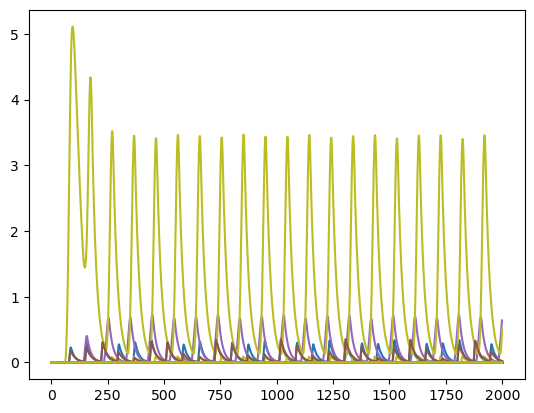

In [8]:
R = Rs[0,0]


wTable = pd.read_csv("../data/manc t1 connectome data/wTable_20231020_DNtoMN_unsorted_withModules.csv",index_col=0)
nonMns = wTable.loc[(wTable["bodyId"]==10093) | (wTable["bodyId"]==10707) | (wTable["bodyId"]==13905) | (wTable["bodyId"]==11751)]
mnIdxs = wTable.loc[wTable["class"]=="motor neuron"].index


# for i in nonMns.index:
for i in mnIdxs:
    plt.plot(R[i])
    #plt.plot(Rtsp[i])

print(np.mean(R))


In [5]:
R[0]

Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [7]:
def print_pytree(pytree):
    """
    path_filter: function that takes key_path tuple and returns True/False
    """
    def process_leaf(key_path, leaf):
       print(f"Key Path: {key_path[0]}, Leaf: {leaf.shape} dype: {leaf.dtype}")

    return jax.tree.map_with_path(process_leaf, pytree)
print_pytree(state)

Key Path: .W_mask, Leaf: (4561, 4561) dype: float32
Key Path: .interneuron_mask, Leaf: (4561,) dype: bool
Key Path: .level, Leaf: (1,) dype: int32
Key Path: .total_removed_neurons, Leaf: (4561,) dype: bool
Key Path: .removed_stim_neurons, Leaf: (4561,) dype: bool
Key Path: .neurons_put_back, Leaf: (4561,) dype: bool
Key Path: .last_removed, Leaf: (4561,) dype: bool
Key Path: .remove_p, Leaf: (4442,) dype: float32
Key Path: .min_circuit, Leaf: (1,) dype: bool
Key Path: .keys, Leaf: (2,) dype: uint32


Pruning_state(W_mask=None, interneuron_mask=None, level=None, total_removed_neurons=None, removed_stim_neurons=None, neurons_put_back=None, last_removed=None, remove_p=None, min_circuit=None, keys=None)

In [92]:

# def update_single_sim_state(state, R, mn_idxs, in_idxs, oscillation_threshold):
"""Update state for a single simulation - now handles convergence check inside JIT"""
(W_mask,interneuron_mask,level,total_removed_neurons,removed_stim_neurons,
    neurons_put_back,last_removed,remove_p,min_circuit,key) = state

# (remove_neurons, neurons_put_back, last_removed, 
#     p, level, removed_stim_neurons, key) = state

start = int(cfg.sim.pulseStart / cfg.sim.dt) + 100

# Get active MN activity using JAX-compatible approach
max_frs = jnp.max(R, axis=-1)
mn_mask = jnp.isin(jnp.arange(R.shape[0]), mn_idxs)
active_mask = ((max_frs>0) & mn_mask)  # Combine max_frs with mn_mask to get active neurons

oscillation_score, _ = compute_oscillation_score(R[..., start:], active_mask, prominence=0.05)

# Check if oscillation is below threshold
reset_condition = (oscillation_score < oscillation_threshold) | jnp.isnan(oscillation_score)

def get_pos_val_indices(arr, max_indices=None):
    if max_indices is None:
        max_indices = arr.shape[0]  # Use full array size as max
    
    indices = jnp.where(arr >= 0, size=max_indices, fill_value=-1)[0]
    return indices
@jit
def continue_branch(key):
    # Get max firing rates for all neurons
    max_frs = jnp.max(R, axis=-1)

    # Remove silent interneurons
    silent_mask = (max_frs <= 0)
    
    # Update probabilities based on firing rates
    exclude_mask = (~interneuron_mask) | (silent_mask) | (removed_stim_neurons) # TODO: Check that you don't need to account for neurons_put_back here
    # exclude_mask = (new_neurons_put_back > 0) | (removed_stim_neurons > 0)
    new_p = removal_probability(max_frs, exclude_mask)

    # Check if we can continue
    p_sum = jnp.sum(new_p)
    converged = p_sum <= 1e-10

    # Sample new neuron to remove
    key, subkey = random.split(key)
    neuron_idx = jax_choice(subkey, jnp.arange(len(max_frs)), new_p)
    new_removed_stim_neurons = removed_stim_neurons.at[neuron_idx].set(True)

    # Update new neurons to remove
    new_total_removed_neurons = (silent_mask) | (new_removed_stim_neurons)
    # update total removed neurons
    next_total_removed_neurons = (total_removed_neurons) | (new_total_removed_neurons)
    # Efficiently update W_mask to remove the new neurons
    # Use broadcasting and masking, cast mask to float to preserve W_mask dtype
    W_mask_init = jnp.ones_like(W_mask, dtype=jnp.float32)
    removed_float = next_total_removed_neurons.astype(jnp.float32)
    kept_mask = 1.0 - removed_float # set removed neurons to 0 and kept neurons to 1
    W_mask_new = W_mask_init * kept_mask[:, None] * kept_mask[None, :] 

    return Pruning_state(
                W_mask=W_mask_new,
                interneuron_mask=interneuron_mask,
                level=level,
                total_removed_neurons=next_total_removed_neurons, # Total removed neurons = silient interneurons + new neurons to remove
                neurons_put_back=neurons_put_back,
                removed_stim_neurons=new_removed_stim_neurons,
                last_removed=new_total_removed_neurons,
                remove_p=new_p,
                min_circuit=converged,
                keys=neuron_params.seeds
            )
@jit
def reset_branch(key):
    # Put back the last removed neuron
    reset_neurons_removed = jnp.where(removed_stim_neurons, False, total_removed_neurons)
    # Combine neurons_put_back and last_removed into a single mask
    # new_neurons_put_back = jnp.where((neurons_put_back >= 0) & (last_removed >= 0), 1, -1)

    # Update probabilities to exclude put-back neurons
    exclude_mask = (~interneuron_mask) | (reset_neurons_removed) | (removed_stim_neurons)
    new_p = removal_probability(jnp.ones(len(total_removed_neurons)), exclude_mask)

    # Check if we can continue
    p_sum = jnp.sum(new_p)
    converged = p_sum <= 1e-10

    key, subkey = random.split(key)
    neuron_idx = jax_choice(subkey, jnp.arange(len(total_removed_neurons)), new_p)
    reset_removed_stim_neurons = jnp.full_like(removed_stim_neurons, False, dtype=jnp.bool_)
    new_removed_stim_neurons = reset_removed_stim_neurons.at[neuron_idx].set(True)
    

    # Update new neurons to remove
    new_total_removed_neurons = new_removed_stim_neurons
    # update total removed neurons
    next_total_removed_neurons = (total_removed_neurons) | (new_total_removed_neurons)
    # Efficiently update W_mask to remove the new neurons
    # Use broadcasting and masking, cast mask to float to preserve W_mask dtype
    W_mask_init = jnp.ones_like(W_mask, dtype=jnp.float32)
    removed_float = next_total_removed_neurons.astype(jnp.float32)
    kept_mask = 1.0 - removed_float # set removed neurons to 0 and kept neurons to 1
    W_mask_new = W_mask_init * kept_mask[:, None] * kept_mask[None, :] 

    return Pruning_state(
                W_mask=W_mask_new,
                interneuron_mask=interneuron_mask,
                level=level,
                total_removed_neurons=next_total_removed_neurons, # Total removed neurons = silient interneurons + new neurons to remove
                neurons_put_back=neurons_put_back,
                removed_stim_neurons=new_removed_stim_neurons,
                last_removed=new_total_removed_neurons,
                remove_p=new_p,
                min_circuit=converged,
                keys=neuron_params.seeds
            )

    # return jax.lax.cond(reset_condition, reset_branch, continue_branch, operand=(key))

In [93]:
next_state = continue_branch(key)

In [94]:
(W_mask,interneuron_mask,level,total_removed_neurons,removed_stim_neurons,
    neurons_put_back,last_removed,remove_p,min_circuit,keys) = next_state
# print_pytree(next_state)

In [95]:
jnp.where(next_state.removed_stim_neurons)

(Array([3490], dtype=int32),)

In [96]:
reset_state = reset_branch(key)

In [97]:
jnp.where(reset_state.removed_stim_neurons)

(Array([4298], dtype=int32),)

In [ ]:
# total_removed_neurons = total_removed_neurons.at[31].set(False)
removed_stim_neurons = removed_stim_neurons.at[31].set(True)

In [57]:
reset_neurons_removed = jnp.where(removed_stim_neurons, False, total_removed_neurons)
jnp.where(reset_neurons_removed)

(Array([   0,    1,    2, ..., 4558, 4559, 4560], dtype=int32),)

In [60]:
exclude_mask = (~interneuron_mask) | (reset_neurons_removed) | (total_removed_neurons)
jnp.where(~exclude_mask)

(Array([  31,   70,   72,   82,   83,   86,   97,  108,  113,  124,  127,
         132,  134,  138,  142,  145,  147,  150,  160,  169,  177,  180,
         207,  242,  244,  247,  255,  273,  274,  277,  280,  323,  325,
         332,  348,  425,  485,  502,  516,  535,  536,  601,  609,  614,
         616,  617,  624,  630,  637,  660,  663,  669,  679,  693,  696,
         699,  703,  715,  739,  749,  757,  763,  773,  811,  812,  855,
         913,  919, 1106, 1108, 1119, 1122, 1153, 1165, 1209, 1218, 1274,
        1278, 1280, 1291, 1332, 1364, 1503, 1516, 1549, 1574, 1603, 1619,
        1630, 1631, 1646, 1725, 1770, 1775, 1777, 1816, 1842, 1861, 1880,
        1912, 1918, 1928, 1940, 2013, 2033, 2126, 2149, 2178, 2200, 2209,
        2214, 2223, 2236, 2267, 2268, 2274, 2295, 2307, 2314, 2362, 2368,
        2432, 2434, 2441, 2479, 2485, 2503, 2508, 2522, 2529, 2587, 2655,
        2657, 2658, 2679, 2714, 2728, 2735, 2745, 2762, 2771, 2773, 2774,
        2807, 2814, 2836, 2864, 2873, 

In [65]:
jnp.where(new_removed_stim_neurons)

(Array([  31, 3490, 4298], dtype=int32),)

In [63]:
# Put back the last removed neuron
reset_neurons_removed = jnp.where(removed_stim_neurons, False, total_removed_neurons)
# Combine neurons_put_back and last_removed into a single mask
# new_neurons_put_back = jnp.where((neurons_put_back >= 0) & (last_removed >= 0), 1, -1)

# Update probabilities to exclude put-back neurons
exclude_mask = (~interneuron_mask) | (reset_neurons_removed) | (removed_stim_neurons)
new_p = removal_probability(jnp.ones(len(total_removed_neurons)), exclude_mask)

# Check if we can continue
p_sum = jnp.sum(new_p)
converged = p_sum <= 1e-10

key, subkey = random.split(key)
neuron_idx = jax_choice(subkey, jnp.arange(len(total_removed_neurons)), new_p)
new_removed_stim_neurons = removed_stim_neurons.at[neuron_idx].set(True)

# Update new neurons to remove
new_total_removed_neurons = new_removed_stim_neurons
# update total removed neurons
next_total_removed_neurons = (total_removed_neurons) | (new_total_removed_neurons)
# Efficiently update W_mask to remove the new neurons
# Use broadcasting and masking, cast mask to float to preserve W_mask dtype
W_mask_init = jnp.ones_like(W_mask, dtype=jnp.float32)
removed_float = next_total_removed_neurons.astype(jnp.float32)
kept_mask = 1.0 - removed_float # set removed neurons to 0 and kept neurons to 1
W_mask_new = W_mask_init * kept_mask[:, None] * kept_mask[None, :] 

Pruning_state(
    W_mask=W_mask_new,
    interneuron_mask=interneuron_mask,
    level=level,
    total_removed_neurons=next_total_removed_neurons, # Total removed neurons = silient interneurons + new neurons to remove
    neurons_put_back=neurons_put_back,
    removed_stim_neurons=new_removed_stim_neurons,
    last_removed=new_total_removed_neurons,
    remove_p=new_p,
    min_circuit=converged,
    keys=neuron_params.seeds
)


Pruning_state(W_mask=Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), interneuron_mask=Array([ True,  True,  True, ...,  True,  True,  True], dtype=bool), level=Array([0], dtype=int32), total_removed_neurons=Array([ True,  True,  True, ...,  True,  True,  True], dtype=bool), removed_stim_neurons=Array([False, False, False, ..., False, False, False], dtype=bool), neurons_put_back=Array([False, False, False, ..., False, False, False], dtype=bool), last_removed=Array([False, False, False, ..., False, False, False], dtype=bool), remove_p=Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), min_circuit=Array(False, dtype=bool), keys=Array([[ 726863002, 2265770120]], dtype=uint32))

In [96]:
removed_stim_neurons = removed_stim_neurons.at[0].set(1)
new_neurons_put_back = neurons_put_back.at[1:3].set(1)
jnp.where(new_neurons_put_back>0)[0], jnp.where(removed_stim_neurons>0)[0]
combined_mask = (new_neurons_put_back > 0) | (removed_stim_neurons > 0)
jnp.where(combined_mask)[0]

Array([0, 1, 2], dtype=int32)

In [ ]:
R = Rs[0,0]


wTable = pd.read_csv("../data/manc t1 connectome data/wTable_20231020_DNtoMN_unsorted_withModules.csv",index_col=0)
nonMns = wTable.loc[(wTable["bodyId"]==10093) | (wTable["bodyId"]==10707) | (wTable["bodyId"]==13905) | (wTable["bodyId"]==11751)]
mnIdxs = wTable.loc[wTable["class"]=="motor neuron"].index


for i in nonMns.index:
# for i in mnIdxs:
    plt.plot(R[i])
    #plt.plot(Rtsp[i])

print(np.mean(R))


In [ ]:
class Pruning_state(NamedTuple):
    """Parameters for pruning simulation."""
    W_mask: jnp.ndarray
    in_idxs: jnp.ndarray
    level: jnp.ndarray
    removed_neurons: jnp.ndarray
    neurons_put_back: jnp.ndarray
    last_removed: jnp.ndarray
    remove_p: jnp.ndarray
    min_circuit: jnp.ndarray
    keys: jnp.ndarray
    

state = Pruning_state(
    W_mask= neuron_params.W[None, :] * jnp.ones((n_sims, neuron_params.W.shape[0], neuron_params.W.shape[1])),
    in_idxs=in_idxs,
    level=jnp.zeros(n_sims, dtype=jnp.int32),
    removed_neurons=jnp.full([n_sims, neuron_params.removed_neurons.shape[-1]], -1, dtype=jnp.int32),
    neurons_put_back=jnp.full([n_sims, neuron_params.removed_neurons.shape[-1]], -1, dtype=jnp.int32),
    last_removed=jnp.full([n_sims, neuron_params.removed_neurons.shape[-1]], -1, dtype=jnp.int32),
    remove_p=jnp.array(p_arrays),
    min_circuit=jnp.full(n_sims, False),
    keys=neuron_params.seeds
)



In [36]:
(new_W_mask,new_in_idxs,new_level,new_removed_neurons,new_neurons_put_back,new_last_removed,new_remove_p,new_min_circuit,new_keys,) = state

In [ ]:
state = Pruning_state(
    W_mask= neuron_params.W[None, :] * jnp.ones((n_sims, neuron_params.W.shape[0], neuron_params.W.shape[1])),
    in_idxs=in_idxs,
    level=jnp.zeros(n_sims, dtype=jnp.int32),
    removed_neurons=jnp.full([n_sims, neuron_params.removed_neurons.shape[-1]], -1, dtype=jnp.int32),
    neurons_put_back=jnp.full([n_sims, neuron_params.removed_neurons.shape[-1]], -1, dtype=jnp.int32),
    last_removed=jnp.full([n_sims, neuron_params.removed_neurons.shape[-1]], -1, dtype=jnp.int32),
    remove_p=jnp.array(p_arrays),
    min_circuit=jnp.full(n_sims, False),
    keys=neuron_params.seeds
)

Array([0.00022512, 0.00022512, 0.00022512, ..., 0.00022512, 0.00022512,
       0.00022512], dtype=float32)

In [ ]:
neuron_params.removed_neurons = temp_removed.at[i].set(new_remove_neurons)

AttributeError: can't set attribute

In [20]:
neurons_put_back.at[in_idxs[neuron_idx]].set(1)


AttributeError: 'list' object has no attribute 'at'

In [ ]:
# Initialize state arrays
level = jnp.zeros(n_sims, dtype=jnp.int32)
last_removed = jnp.full(n_sims, -1, dtype=jnp.int32)  # Use -1 for None
neurons_put_back = [jnp.array([], dtype=jnp.int32) for _ in range(n_sims)]
min_circuit = jnp.full(n_sims, False)
oscillation_threshold=0.1

# Initialize probabilities
p_arrays = []
for i in range(n_sims):
    exclude_mask = jnp.isin(in_idxs, jnp.concatenate([
        jnp.array(remove_neurons[i]), 
        removed_stim_neurons[i]
    ]))
    p_i = removal_probability(jnp.ones(len(in_idxs)), exclude_mask)
    p_arrays.append(p_i)


In [ ]:
max_frs[mn_idxs].shape, (max_frs[mn_idxs] > 0).shape

In [ ]:

max_frs = jnp.max(R, axis=-1)
active_mn_mask = max_frs[mn_idxs] > 0
active_mn_idxs = jnp.where(active_mn_mask, mn_idxs, -1)
active_mn_idxs = jnp.extract(active_mn_idxs >= 0, active_mn_idxs)

start = 250
end = R.shape[1]  # Use full time range
# active_mn_idxs = mn_idxs[max_frs[mn_idxs] > 0]


In [ ]:

# Create master random key
master_key = random.PRNGKey(cfg.experiment.seed)
iter_start=0
# Main pruning loop
iteration = iter_start
max_iterations = 1000  # Safety limit

# while not jnp.all(min_circuit) and iteration < max_iterations:
print(f"Iteration {iteration}")

# Resample seeds for non-converged simulations
resample_idxs = jnp.where(~min_circuit)[0]
master_key, *subkeys = random.split(master_key, len(resample_idxs) + 1)

# add in sim here

Rs = results[1][0]
# Update each simulation state
# for i in range(n_sims):
i = 0


state = (
    jnp.array(remove_neurons[i]),
    neurons_put_back[i],
    last_removed[i],
    p_arrays[i],
    level[i],
    removed_stim_neurons[i],
    subkeys[i] if i < len(subkeys) else master_key
)


In [ ]:

# This function is JIT compiled but doesn't need to handle min_circuit
new_state = update_single_sim_state(state, Rs, mn_idxs, in_idxs, oscillation_threshold
)


In [ ]:
new_state = update_single_sim_state(state, R, mn_idxs, in_idxs, oscillation_threshold)

## Load data

In [4]:
results = sparse.load_npz(cfg.paths.ckpt_dir  / f"{cfg.experiment.name}_Rs.npz").todense().astype(np.float32)
W_mask = sparse.load_npz(cfg.paths.ckpt_dir / f"{cfg.experiment.name}_W_mask.npz").todense().astype(np.float32)
total_removed_neurons = sparse.load_npz(cfg.paths.ckpt_dir / f"{cfg.experiment.name}_total_removed.npz").todense().astype(np.bool_)

In [5]:
jnp.where(~total_removed_neurons[0])[0]

Array([  31,   97,  108,  113,  132,  134,  142,  150,  451,  536,  582,
        598,  626,  660,  669,  679,  713,  722,  739,  763,  793,  848,
        855,  860,  868,  887,  917,  978,  991, 1020, 1024, 1043, 1044,
       1064, 1073, 1104, 1108, 1147, 1153, 1169, 1182, 1211, 1270, 1302,
       1307, 1354, 1357, 1367, 1396, 1412, 1436, 1473, 1474, 1482, 1498,
       1501, 1503, 1549, 1557, 1573, 1574, 1580, 1685, 1696, 1723, 1725,
       1729, 1743, 1773, 1787, 1805, 1816, 1828, 1838, 1842, 1927, 1940,
       1973, 2058, 2065, 2071, 2083, 2086, 2107, 2150, 2153, 2165, 2176,
       2209, 2214, 2256, 2260, 2279, 2303, 2309, 2368, 2379, 2380, 2403,
       2408, 2409, 2410, 2419, 2508, 2522, 2528, 2581, 2595, 2602, 2605,
       2636, 2656, 2657, 2667, 2682, 2714, 2742, 2790, 2814, 2819, 2821,
       2836, 2877, 2879, 2926, 2991, 3029, 3088, 3108, 3120, 3138, 3224,
       3233, 3283, 3288, 3455, 3462, 3466, 3501, 3502, 3506, 3509, 3686,
       3812, 3911, 4156, 4161, 4173, 4338, 4339, 43

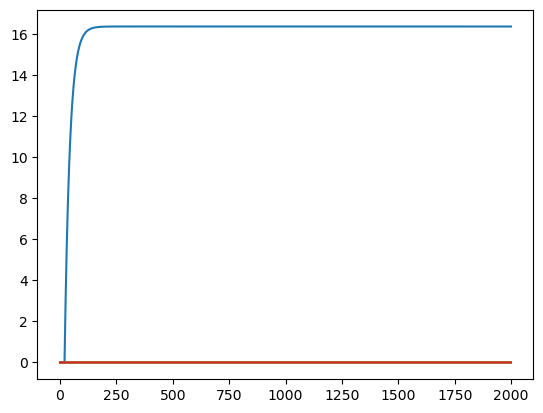

In [11]:
R = results[0,0]


wTable = pd.read_csv("../data/manc t1 connectome data/wTable_20231020_DNtoMN_unsorted_withModules.csv",index_col=0)
nonMns = wTable.loc[(wTable["bodyId"]==10093) | (wTable["bodyId"]==10707) | (wTable["bodyId"]==13905) | (wTable["bodyId"]==11751)]
mnIdxs = wTable.loc[wTable["class"]=="motor neuron"].index


for i in nonMns.index:
# for i in mnIdxs:
    plt.plot(R[i])



# Stim Adjustment Testing

In [ ]:


def run_with_stim_adjustment(self,maxIters=10,clampedNeurons=[],clampedRates=None,nActiveUpper=500,nActiveLower=5,nHighFrUpper=100):
    nextHighest = None
    nextLowest = None

    for i in range(maxIters):
        self.run(clampedNeurons=clampedNeurons,clampedRates=clampedRates)
        R = self.R

        nActive = sum(np.sum(R,1)>0)
        nHighFr = sum(np.max(R,1)>100)

        currInputs = self.inputs.copy()

        print(f"Run {i}")
        print(f"max stimI = {np.max(currInputs)}")
        print(f"nActive: {nActive}")
        print(f"nHighFr: {nHighFr}")

        if (nActive > nActiveUpper) or (nHighFr > nHighFrUpper): # too strong
            if nextLowest is None:
                newInputs = currInputs/2
            else:
                newInputs = (currInputs+nextLowest)/2
            nextHighest = currInputs
        elif (nActive < nActiveLower): # too weak
            if nextHighest is None:
                newInputs = currInputs*2
            else:
                newInputs = (currInputs+nextHighest)/2
            nextLowest = currInputs
        else:
            break

        self.set_input(newInputs)

In [ ]:

# Note: The run_with_stim_adjustment function cannot be easily JIT-compiled
# because it involves loops with data-dependent control flow and side effects.
# Here's a restructured version that separates the JIT-able parts:

@jit
def compute_activity_metrics(R):
    """JIT-compatible function to compute activity metrics."""
    n_active = jnp.sum(jnp.sum(R, axis=1) > 0)
    n_high_fr = jnp.sum(jnp.max(R, axis=1) > 100)
    return n_active, n_high_fr

@jit
def update_inputs_binary_search(curr_inputs, next_lowest, next_highest, 
                               n_active, n_high_fr, n_active_upper, 
                               n_active_lower, n_high_fr_upper):
    """JIT-compatible input update logic."""
    
    # Determine if stimulation is too strong
    too_strong = (n_active > n_active_upper) | (n_high_fr > n_high_fr_upper)
    too_weak = n_active < n_active_lower
    
    # Update inputs based on binary search logic
    def update_for_too_strong():
        new_inputs = jnp.where(
            next_lowest is None,
            curr_inputs / 2,
            (curr_inputs + next_lowest) / 2
        )
        new_next_highest = curr_inputs
        return new_inputs, next_lowest, new_next_highest
    
    def update_for_too_weak():
        new_inputs = jnp.where(
            next_highest is None,
            curr_inputs * 2,
            (curr_inputs + next_highest) / 2
        )
        new_next_lowest = curr_inputs
        return new_inputs, new_next_lowest, next_highest
    
    def no_update():
        return curr_inputs, next_lowest, next_highest
    
    # Apply updates conditionally
    new_inputs, new_next_lowest, new_next_highest = jax.lax.cond(
        too_strong,
        update_for_too_strong,
        lambda: jax.lax.cond(
            too_weak,
            update_for_too_weak,
            no_update
        )
    )
    
    converged = ~too_strong & ~too_weak
    
    return new_inputs, new_next_lowest, new_next_highest, converged

# Example usage:
def run_with_stim_adjustment_jax(simulation_runner, max_iters=10, 
                                clamped_neurons=None, clamped_rates=None,
                                n_active_upper=500, n_active_lower=5, 
                                n_high_fr_upper=100):
    """
    JAX-compatible version of run_with_stim_adjustment.
    Note: This requires the simulation_runner to be compatible with JAX.
    """
    next_highest = None
    next_lowest = None
    
    for i in range(max_iters):
        # Run simulation (this part depends on your simulation framework)
        R = simulation_runner.run(clamped_neurons=clamped_neurons, 
                                 clamped_rates=clamped_rates)
        
        # Compute metrics (JIT-compiled)
        n_active, n_high_fr = compute_activity_metrics(R)
        curr_inputs = simulation_runner.get_inputs()
        
        print(f"Run {i}")
        print(f"max stimI = {jnp.max(curr_inputs)}")
        print(f"nActive: {n_active}")
        print(f"nHighFr: {n_high_fr}")
        
        # Update inputs (JIT-compiled)
        new_inputs, next_lowest, next_highest, converged = update_inputs_binary_search(
            curr_inputs, next_lowest, next_highest, n_active, n_high_fr,
            n_active_upper, n_active_lower, n_high_fr_upper
        )
        
        if converged:
            break
            
        simulation_runner.set_input(new_inputs)

# Additional utility functions for JAX compatibility:

@jit
def safe_divide(x, y, default=0.0):
    """Safe division that handles division by zero."""
    return jnp.where(y == 0, default, x / y)

@jit
def safe_max(x, default=0.0):
    """Safe max that handles empty arrays."""
    return jnp.where(len(x) == 0, default, jnp.max(x))

@jit
def safe_min(x, default=0.0):
    """Safe min that handles empty arrays."""
    return jnp.where(len(x) == 0, default, jnp.min(x))